# 1. Import and Install Dependencies

In [1]:
pip install opencv-python mediapipe sklearn matplotlib gTTS playsound==1.2.2 pyttsx3

     ---------------------------------------- 35.6/35.6 MB 1.3 MB/s eta 0:00:00
     ---------------------------------------- 49.8/49.8 MB 1.3 MB/s eta 0:00:00
  Preparing metadata (setup.py): started
  Preparing metadata (setup.py): finished with status 'done'
     ---------------------------------------- 42.5/42.5 MB 1.3 MB/s eta 0:00:00
     -------------------------------------- 904.2/904.2 kB 1.6 MB/s eta 0:00:00
     -------------------------------------- 124.6/124.6 kB 2.4 MB/s eta 0:00:00
     ---------------------------------------- 96.6/96.6 kB 2.8 MB/s eta 0:00:00
  Created wheel for sklearn: filename=sklearn-0.0.post1-py3-none-any.whl size=2936 sha256=c1067d53814267055e141426b10618c01c80c1fdba2a759a0c8bdf9e19925e65
  Stored in directory: c:\users\shrey\appdata\local\pip\cache\wheels\f8\e0\3d\9d0c2020c44a519b9f02ab4fa6d2a4a996c98d79ab2f569fa1
Successfully built sklearn
  Attempting uninstall: click
    Found existing installation: click 8.0.4
    Uninstalling click-8.0.4:
  

In [2]:
pip install mediapipe

Note: you may need to restart the kernel to use updated packages.


In [3]:
import cv2
import numpy as np
import os
from matplotlib import pyplot as plt
import time
import mediapipe as mp

import gtts  
from playsound import playsound 

# 2. Keypoints using MP Holistic

In [4]:
#pip list

In [5]:
mp_holistic = mp.solutions.holistic # Holistic model
mp_drawing = mp.solutions.drawing_utils # Drawing utilities

In [6]:
def mediapipe_detection(image, model):
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB) # COLOR CONVERSION BGR 2 RGB
    image.flags.writeable = False                  # Image is no longer writeable
    results = model.process(image)                 # Make prediction
    image.flags.writeable = True                   # Image is now writeable 
    image = cv2.cvtColor(image, cv2.COLOR_RGB2BGR) # COLOR COVERSION RGB 2 BGR
    return image, results

In [7]:
def draw_landmarks(image, results):
    mp_drawing.draw_landmarks(image, results.face_landmarks, mp_holistic.FACEMESH_TESSELATION) # Draw face connections
    mp_drawing.draw_landmarks(image, results.pose_landmarks, mp_holistic.POSE_CONNECTIONS) # Draw pose connections
    mp_drawing.draw_landmarks(image, results.left_hand_landmarks, mp_holistic.HAND_CONNECTIONS) # Draw left hand connections
    mp_drawing.draw_landmarks(image, results.right_hand_landmarks, mp_holistic.HAND_CONNECTIONS) # Draw right hand connections

In [8]:
def draw_styled_landmarks(image, results):
    # Draw face connections
    mp_drawing.draw_landmarks(image, results.face_landmarks, mp_holistic.FACEMESH_TESSELATION, 
                             mp_drawing.DrawingSpec(color=(80,110,10), thickness=1, circle_radius=1), 
                             mp_drawing.DrawingSpec(color=(80,256,121), thickness=1, circle_radius=1)
                             ) 
    # Draw pose connections
    mp_drawing.draw_landmarks(image, results.pose_landmarks, mp_holistic.POSE_CONNECTIONS,
                             mp_drawing.DrawingSpec(color=(80,22,10), thickness=2, circle_radius=4), 
                             mp_drawing.DrawingSpec(color=(80,44,121), thickness=2, circle_radius=2)
                             ) 
    # Draw left hand connections
    mp_drawing.draw_landmarks(image, results.left_hand_landmarks, mp_holistic.HAND_CONNECTIONS, 
                             mp_drawing.DrawingSpec(color=(121,22,76), thickness=2, circle_radius=4), 
                             mp_drawing.DrawingSpec(color=(121,44,250), thickness=2, circle_radius=2)
                             ) 
    # Draw right hand connections  
    mp_drawing.draw_landmarks(image, results.right_hand_landmarks, mp_holistic.HAND_CONNECTIONS, 
                             mp_drawing.DrawingSpec(color=(245,117,66), thickness=2, circle_radius=4), 
                             mp_drawing.DrawingSpec(color=(245,66,230), thickness=2, circle_radius=2)
                             ) 

In [9]:
cap = cv2.VideoCapture(0)
# Set mediapipe model 
with mp_holistic.Holistic(min_detection_confidence=0.5, min_tracking_confidence=0.5) as holistic:
    while cap.isOpened():

        # Read feed
        ret, frame = cap.read()

        # Make detections
        image, results = mediapipe_detection(frame, holistic)
        print(results)
        
        # Draw landmarks
        draw_styled_landmarks(image, results)

        # Show to screen
        cv2.imshow('OpenCV Feed', image)

        # Break gracefully
        if cv2.waitKey(10) & 0xFF == ord('q'):
            break
    cap.release()
    cv2.destroyAllWindows()

<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.soluti

In [10]:
draw_landmarks(frame, results)

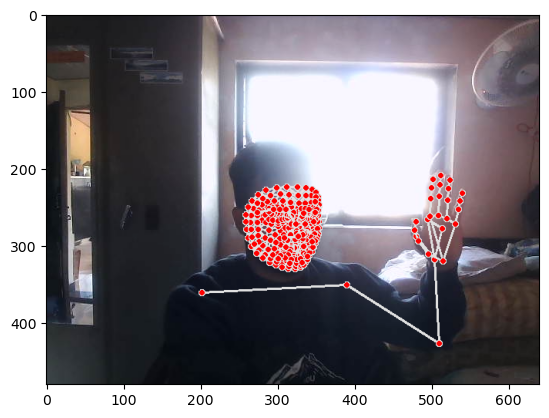

In [11]:
plt.imshow(cv2.cvtColor(frame, cv2.COLOR_BGR2RGB))

# 3. Extract Keypoint Values

In [12]:
def extract_keypoints(results):
    pose = np.array([[res.x, res.y, res.z, res.visibility] for res in results.pose_landmarks.landmark]).flatten() if results.pose_landmarks else np.zeros(33*4)
    face = np.array([[res.x, res.y, res.z] for res in results.face_landmarks.landmark]).flatten() if results.face_landmarks else np.zeros(468*3)
    lh = np.array([[res.x, res.y, res.z] for res in results.left_hand_landmarks.landmark]).flatten() if results.left_hand_landmarks else np.zeros(21*3)
    rh = np.array([[res.x, res.y, res.z] for res in results.right_hand_landmarks.landmark]).flatten() if results.right_hand_landmarks else np.zeros(21*3)
    return np.concatenate([pose, face, lh, rh])

In [13]:
468*3+33*4+21*3+21*3

1662

# 4. Setup Folders for Collection

In [14]:
# Path for exported data, numpy arrays
DATA_PATH = os.path.join('MP_Data') 

# Actions that we try to detect
actions = np.array(['Namaskar', 'Dhanyawad', 'Mi thik ahe', 'Kay kartay','Bharat','Somvar','Mangalvar'])
#actions = np.array([])
# Thirty videos worth of data
no_sequences = 30

# Videos are going to be 30 frames in length
sequence_length = 10

In [15]:
# hello
## 0
## 1
## 2
## ...
## 29
# thanks

# I love you

In [16]:
for action in actions: 
    for sequence in range(no_sequences):
        try: 
            os.makedirs(os.path.join(DATA_PATH, action, str(sequence)))
        except:
            pass

# 5. Collect Keypoint Values for Training and Testing

In [ ]:
cap = cv2.VideoCapture(0)
# Set mediapipe model 
with mp_holistic.Holistic(min_detection_confidence=0.5, min_tracking_confidence=0.5) as holistic:
    
    # NEW LOOP
    # Loop through actions
    for action in actions:
        # Loop through sequences aka videos
        for sequence in range(no_sequences):
            # Loop through video length aka sequence length
            for frame_num in range(sequence_length):

                # Read feed
                ret, frame = cap.read()

                # Make detections
                image, results = mediapipe_detection(frame, holistic)
#                 print(results)

                # Draw landmarks
                draw_styled_landmarks(image, results)
                
                # NEW Apply wait logic
                if frame_num == 0: 
                    cv2.putText(image, 'STARTING COLLECTION', (120,200), 
                               cv2.FONT_HERSHEY_SIMPLEX, 1, (0,255, 0), 4, cv2.LINE_AA)
                    cv2.putText(image, 'Collecting frames for {} Video Number {}'.format(action, sequence), (15,12), 
                               cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 0, 255), 1, cv2.LINE_AA)
                    # Show to screen
                    cv2.imshow('OpenCV Feed', image)
                    cv2.waitKey(2000)
                else: 
                    cv2.putText(image, 'Collecting frames for {} Video Number {}'.format(action, sequence), (15,12), 
                               cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 0, 255), 1, cv2.LINE_AA)
                    # Show to screen
                    cv2.imshow('OpenCV Feed', image)
                
                # NEW Export keypoints
                keypoints = extract_keypoints(results)
                npy_path = os.path.join(DATA_PATH, action, str(sequence), str(frame_num))
                np.save(npy_path, keypoints)

                # Break gracefully
                if cv2.waitKey(10) & 0xFF == ord('q'):
                    break
                    
    cap.release()
    cv2.destroyAllWindows()

In [ ]:
cap.release()
cv2.destroyAllWindows()

# 6. Preprocess Data and Create Labels and Features

In [19]:
pip install tensorflow

     -------------------------------------- 266.3/266.3 MB 1.3 MB/s eta 0:00:00
     ---------------------------------------- 65.5/65.5 kB 3.5 MB/s eta 0:00:00
     ---------------------------------------- 1.5/1.5 MB 1.5 MB/s eta 0:00:00
     ---------------------------------------- 57.5/57.5 kB 3.1 MB/s eta 0:00:00
     ---------------------------------------- 6.0/6.0 MB 1.4 MB/s eta 0:00:00
     ---------------------------------------- 3.7/3.7 MB 1.4 MB/s eta 0:00:00
     -------------------------------------- 439.2/439.2 kB 1.6 MB/s eta 0:00:00
     ---------------------------------------- 14.2/14.2 MB 1.4 MB/s eta 0:00:00
     ---------------------------------------- 1.7/1.7 MB 1.5 MB/s eta 0:00:00
     -------------------------------------- 895.9/895.9 kB 1.6 MB/s eta 0:00:00
     -------------------------------------- 177.0/177.0 kB 3.6 MB/s eta 0:00:00
     -------------------------------------- 781.3/781.3 kB 1.5 MB/s eta 0:00:00
     -------------------------------------- 151.

ERROR: Could not install packages due to an OSError: [WinError 5] Access is denied: 'C:\\Users\\shrey\\anaconda3\\Lib\\site-packages\\google\\~rotobuf\\internal\\_api_implementation.cp39-win_amd64.pyd'
Consider using the `--user` option or check the permissions.



In [22]:
import tensorflow
from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import to_categorical

In [23]:
label_map = {label:num for num, label in enumerate(actions)}

In [24]:
label_map

{'Namaskar': 0,
 'Dhanyawad': 1,
 'Mi thik ahe': 2,
 'Kay kartay': 3,
 'Bharat': 4,
 'Somvar': 5,
 'Mangalvar': 6}

In [25]:
sequences, labels = [], []
for action in actions:
    print("se",no_sequences)
    for sequence in range(no_sequences):
        window = []
        for frame_num in range(sequence_length):
            print(str(sequence),frame_num,"sq","frmn")
            
            res = np.load(os.path.join(DATA_PATH, action, str(sequence), "{}.npy".format(frame_num)))
            window.append(res)
        sequences.append(window)
        labels.append(label_map[action])

se 30
0 0 sq frmn
0 1 sq frmn
0 2 sq frmn
0 3 sq frmn
0 4 sq frmn
0 5 sq frmn
0 6 sq frmn
0 7 sq frmn
0 8 sq frmn
0 9 sq frmn
1 0 sq frmn
1 1 sq frmn
1 2 sq frmn
1 3 sq frmn
1 4 sq frmn
1 5 sq frmn
1 6 sq frmn
1 7 sq frmn
1 8 sq frmn
1 9 sq frmn
2 0 sq frmn
2 1 sq frmn
2 2 sq frmn
2 3 sq frmn
2 4 sq frmn
2 5 sq frmn
2 6 sq frmn
2 7 sq frmn
2 8 sq frmn
2 9 sq frmn
3 0 sq frmn
3 1 sq frmn
3 2 sq frmn
3 3 sq frmn
3 4 sq frmn
3 5 sq frmn
3 6 sq frmn
3 7 sq frmn
3 8 sq frmn
3 9 sq frmn
4 0 sq frmn
4 1 sq frmn
4 2 sq frmn
4 3 sq frmn
4 4 sq frmn
4 5 sq frmn
4 6 sq frmn
4 7 sq frmn
4 8 sq frmn
4 9 sq frmn
5 0 sq frmn
5 1 sq frmn
5 2 sq frmn
5 3 sq frmn
5 4 sq frmn
5 5 sq frmn
5 6 sq frmn
5 7 sq frmn
5 8 sq frmn
5 9 sq frmn
6 0 sq frmn
6 1 sq frmn
6 2 sq frmn
6 3 sq frmn
6 4 sq frmn
6 5 sq frmn
6 6 sq frmn
6 7 sq frmn
6 8 sq frmn
6 9 sq frmn
7 0 sq frmn
7 1 sq frmn
7 2 sq frmn
7 3 sq frmn
7 4 sq frmn
7 5 sq frmn
7 6 sq frmn
7 7 sq frmn
7 8 sq frmn
7 9 sq frmn
8 0 sq frmn
8 1 sq frmn
8 2 sq frm

5 4 sq frmn
5 5 sq frmn
5 6 sq frmn
5 7 sq frmn
5 8 sq frmn
5 9 sq frmn
6 0 sq frmn
6 1 sq frmn
6 2 sq frmn
6 3 sq frmn
6 4 sq frmn
6 5 sq frmn
6 6 sq frmn
6 7 sq frmn
6 8 sq frmn
6 9 sq frmn
7 0 sq frmn
7 1 sq frmn
7 2 sq frmn
7 3 sq frmn
7 4 sq frmn
7 5 sq frmn
7 6 sq frmn
7 7 sq frmn
7 8 sq frmn
7 9 sq frmn
8 0 sq frmn
8 1 sq frmn
8 2 sq frmn
8 3 sq frmn
8 4 sq frmn
8 5 sq frmn
8 6 sq frmn
8 7 sq frmn
8 8 sq frmn
8 9 sq frmn
9 0 sq frmn
9 1 sq frmn
9 2 sq frmn
9 3 sq frmn
9 4 sq frmn
9 5 sq frmn
9 6 sq frmn
9 7 sq frmn
9 8 sq frmn
9 9 sq frmn
10 0 sq frmn
10 1 sq frmn
10 2 sq frmn
10 3 sq frmn
10 4 sq frmn
10 5 sq frmn
10 6 sq frmn
10 7 sq frmn
10 8 sq frmn
10 9 sq frmn
11 0 sq frmn
11 1 sq frmn
11 2 sq frmn
11 3 sq frmn
11 4 sq frmn
11 5 sq frmn
11 6 sq frmn
11 7 sq frmn
11 8 sq frmn
11 9 sq frmn
12 0 sq frmn
12 1 sq frmn
12 2 sq frmn
12 3 sq frmn
12 4 sq frmn
12 5 sq frmn
12 6 sq frmn
12 7 sq frmn
12 8 sq frmn
12 9 sq frmn
13 0 sq frmn
13 1 sq frmn
13 2 sq frmn
13 3 sq frmn
13 4 s

10 7 sq frmn
10 8 sq frmn
10 9 sq frmn
11 0 sq frmn
11 1 sq frmn
11 2 sq frmn
11 3 sq frmn
11 4 sq frmn
11 5 sq frmn
11 6 sq frmn
11 7 sq frmn
11 8 sq frmn
11 9 sq frmn
12 0 sq frmn
12 1 sq frmn
12 2 sq frmn
12 3 sq frmn
12 4 sq frmn
12 5 sq frmn
12 6 sq frmn
12 7 sq frmn
12 8 sq frmn
12 9 sq frmn
13 0 sq frmn
13 1 sq frmn
13 2 sq frmn
13 3 sq frmn
13 4 sq frmn
13 5 sq frmn
13 6 sq frmn
13 7 sq frmn
13 8 sq frmn
13 9 sq frmn
14 0 sq frmn
14 1 sq frmn
14 2 sq frmn
14 3 sq frmn
14 4 sq frmn
14 5 sq frmn
14 6 sq frmn
14 7 sq frmn
14 8 sq frmn
14 9 sq frmn
15 0 sq frmn
15 1 sq frmn
15 2 sq frmn
15 3 sq frmn
15 4 sq frmn
15 5 sq frmn
15 6 sq frmn
15 7 sq frmn
15 8 sq frmn
15 9 sq frmn
16 0 sq frmn
16 1 sq frmn
16 2 sq frmn
16 3 sq frmn
16 4 sq frmn
16 5 sq frmn
16 6 sq frmn
16 7 sq frmn
16 8 sq frmn
16 9 sq frmn
17 0 sq frmn
17 1 sq frmn
17 2 sq frmn
17 3 sq frmn
17 4 sq frmn
17 5 sq frmn
17 6 sq frmn
17 7 sq frmn
17 8 sq frmn
17 9 sq frmn
18 0 sq frmn
18 1 sq frmn
18 2 sq frmn
18 3 sq frmn

19 7 sq frmn
19 8 sq frmn
19 9 sq frmn
20 0 sq frmn
20 1 sq frmn
20 2 sq frmn
20 3 sq frmn
20 4 sq frmn
20 5 sq frmn
20 6 sq frmn
20 7 sq frmn
20 8 sq frmn
20 9 sq frmn
21 0 sq frmn
21 1 sq frmn
21 2 sq frmn
21 3 sq frmn
21 4 sq frmn
21 5 sq frmn
21 6 sq frmn
21 7 sq frmn
21 8 sq frmn
21 9 sq frmn
22 0 sq frmn
22 1 sq frmn
22 2 sq frmn
22 3 sq frmn
22 4 sq frmn
22 5 sq frmn
22 6 sq frmn
22 7 sq frmn
22 8 sq frmn
22 9 sq frmn
23 0 sq frmn
23 1 sq frmn
23 2 sq frmn
23 3 sq frmn
23 4 sq frmn
23 5 sq frmn
23 6 sq frmn
23 7 sq frmn
23 8 sq frmn
23 9 sq frmn
24 0 sq frmn
24 1 sq frmn
24 2 sq frmn
24 3 sq frmn
24 4 sq frmn
24 5 sq frmn
24 6 sq frmn
24 7 sq frmn
24 8 sq frmn
24 9 sq frmn
25 0 sq frmn
25 1 sq frmn
25 2 sq frmn
25 3 sq frmn
25 4 sq frmn
25 5 sq frmn
25 6 sq frmn
25 7 sq frmn
25 8 sq frmn
25 9 sq frmn
26 0 sq frmn
26 1 sq frmn
26 2 sq frmn
26 3 sq frmn
26 4 sq frmn
26 5 sq frmn
26 6 sq frmn
26 7 sq frmn
26 8 sq frmn
26 9 sq frmn
27 0 sq frmn
27 1 sq frmn
27 2 sq frmn
27 3 sq frmn

In [26]:
print (actions)

['Namaskar' 'Dhanyawad' 'Mi thik ahe' 'Kay kartay' 'Bharat' 'Somvar'
 'Mangalvar']


In [27]:
np.array(sequences).shape

(210, 10, 1662)

In [28]:
np.array(labels).shape

(210,)

In [29]:
X = np.array(sequences)

In [30]:
X.shape

(210, 10, 1662)

In [31]:
y = to_categorical(labels).astype(int)

In [32]:
y

array([[1, 0, 0, ..., 0, 0, 0],
       [1, 0, 0, ..., 0, 0, 0],
       [1, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 1],
       [0, 0, 0, ..., 0, 0, 1],
       [0, 0, 0, ..., 0, 0, 1]])

In [33]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3)

In [34]:
X_train.shape

(147, 10, 1662)

# 7. Build and Train LSTM Neural Network

In [35]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from tensorflow.keras.callbacks import TensorBoard

In [36]:
log_dir = os.path.join('Logs')
tb_callback = TensorBoard(log_dir=log_dir)

In [37]:
model = Sequential()
model.add(LSTM(64, return_sequences=True, activation='relu', input_shape=(10,1662)))
model.add(LSTM(128, return_sequences=True, activation='relu'))
model.add(LSTM(64, return_sequences=False, activation='relu'))
model.add(Dense(64, activation='relu'))
model.add(Dense(32, activation='relu'))
model.add(Dense(actions.shape[0], activation='softmax'))

In [38]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 10, 64)            442112    
                                                                 
 lstm_1 (LSTM)               (None, 10, 128)           98816     
                                                                 
 lstm_2 (LSTM)               (None, 64)                49408     
                                                                 
 dense (Dense)               (None, 64)                4160      
                                                                 
 dense_1 (Dense)             (None, 32)                2080      
                                                                 
 dense_2 (Dense)             (None, 7)                 231       
                                                                 
Total params: 596,807
Trainable params: 596,807
Non-trai

In [39]:
res = [.7, 0.2, 0.1]

In [40]:
actions[np.argmax(res)]

'Namaskar'

In [41]:
model.compile(optimizer='Adam', loss='categorical_crossentropy', metrics=['categorical_accuracy'])

In [42]:
model.fit(X_train, y_train, epochs=1000, callbacks=[tb_callback])

Epoch 1/1000
5/5 [==============================] - 2s 16ms/step - loss: 1.9590 - categorical_accuracy: 0.1429
Epoch 2/1000
5/5 [==============================] - 0s 15ms/step - loss: 1.9443 - categorical_accuracy: 0.1837
Epoch 3/1000
5/5 [==============================] - 0s 15ms/step - loss: 1.8737 - categorical_accuracy: 0.1769
Epoch 4/1000
5/5 [==============================] - 0s 15ms/step - loss: 1.6742 - categorical_accuracy: 0.3401
Epoch 5/1000
5/5 [==============================] - 0s 16ms/step - loss: 1.5188 - categorical_accuracy: 0.3537
Epoch 6/1000
5/5 [==============================] - 0s 16ms/step - loss: 1.5611 - categorical_accuracy: 0.4082
Epoch 7/1000
5/5 [==============================] - 0s 16ms/step - loss: 1.4974 - categorical_accuracy: 0.3469
Epoch 8/1000
5/5 [==============================] - 0s 16ms/step - loss: 1.5218 - categorical_accuracy: 0.2653
Epoch 9/1000
5/5 [==============================] - 0s 17ms/step - loss: 1.3885 - categorical_accuracy: 0.4354
E

5/5 [==============================] - 0s 16ms/step - loss: 0.2292 - categorical_accuracy: 0.8980
Epoch 75/1000
5/5 [==============================] - 0s 16ms/step - loss: 0.1923 - categorical_accuracy: 0.9320
Epoch 76/1000
5/5 [==============================] - 0s 16ms/step - loss: 0.1826 - categorical_accuracy: 0.9252
Epoch 77/1000
5/5 [==============================] - 0s 16ms/step - loss: 0.3431 - categorical_accuracy: 0.8639
Epoch 78/1000
5/5 [==============================] - 0s 16ms/step - loss: 0.3387 - categorical_accuracy: 0.8503
Epoch 79/1000
5/5 [==============================] - 0s 16ms/step - loss: 0.3216 - categorical_accuracy: 0.8707
Epoch 80/1000
5/5 [==============================] - 0s 16ms/step - loss: 0.2893 - categorical_accuracy: 0.8844
Epoch 81/1000
5/5 [==============================] - 0s 16ms/step - loss: 0.3159 - categorical_accuracy: 0.8776
Epoch 82/1000
5/5 [==============================] - 0s 17ms/step - loss: 0.4100 - categorical_accuracy: 0.8435
Epoch 

5/5 [==============================] - 0s 16ms/step - loss: 0.1881 - categorical_accuracy: 0.9116
Epoch 147/1000
5/5 [==============================] - 0s 16ms/step - loss: 0.2995 - categorical_accuracy: 0.8844
Epoch 148/1000
5/5 [==============================] - 0s 16ms/step - loss: 0.3545 - categorical_accuracy: 0.8912
Epoch 149/1000
5/5 [==============================] - 0s 15ms/step - loss: 0.7347 - categorical_accuracy: 0.7823
Epoch 150/1000
5/5 [==============================] - 0s 15ms/step - loss: 0.6602 - categorical_accuracy: 0.7687
Epoch 151/1000
5/5 [==============================] - 0s 15ms/step - loss: 0.7487 - categorical_accuracy: 0.6803
Epoch 152/1000
5/5 [==============================] - 0s 15ms/step - loss: 0.6106 - categorical_accuracy: 0.7143
Epoch 153/1000
5/5 [==============================] - 0s 16ms/step - loss: 0.4422 - categorical_accuracy: 0.8367
Epoch 154/1000
5/5 [==============================] - 0s 16ms/step - loss: 0.2608 - categorical_accuracy: 0.911

5/5 [==============================] - 0s 17ms/step - loss: 0.0968 - categorical_accuracy: 0.9592
Epoch 219/1000
5/5 [==============================] - 0s 16ms/step - loss: 0.0783 - categorical_accuracy: 0.9456
Epoch 220/1000
5/5 [==============================] - 0s 16ms/step - loss: 0.0683 - categorical_accuracy: 0.9592
Epoch 221/1000
5/5 [==============================] - 0s 16ms/step - loss: 0.0651 - categorical_accuracy: 0.9660
Epoch 222/1000
5/5 [==============================] - 0s 16ms/step - loss: 0.0671 - categorical_accuracy: 0.9592
Epoch 223/1000
5/5 [==============================] - 0s 16ms/step - loss: 0.0727 - categorical_accuracy: 0.9728
Epoch 224/1000
5/5 [==============================] - 0s 16ms/step - loss: 0.0520 - categorical_accuracy: 0.9864
Epoch 225/1000
5/5 [==============================] - 0s 16ms/step - loss: 0.0585 - categorical_accuracy: 0.9728
Epoch 226/1000
5/5 [==============================] - 0s 17ms/step - loss: 0.0548 - categorical_accuracy: 0.959

5/5 [==============================] - 0s 17ms/step - loss: 0.0446 - categorical_accuracy: 0.9796
Epoch 291/1000
5/5 [==============================] - 0s 17ms/step - loss: 0.0416 - categorical_accuracy: 0.9728
Epoch 292/1000
5/5 [==============================] - 0s 16ms/step - loss: 0.0543 - categorical_accuracy: 0.9796
Epoch 293/1000
5/5 [==============================] - 0s 17ms/step - loss: 0.0696 - categorical_accuracy: 0.9592
Epoch 294/1000
5/5 [==============================] - 0s 16ms/step - loss: 0.1176 - categorical_accuracy: 0.9524
Epoch 295/1000
5/5 [==============================] - 0s 16ms/step - loss: 0.0813 - categorical_accuracy: 0.9592
Epoch 296/1000
5/5 [==============================] - 0s 16ms/step - loss: 0.1344 - categorical_accuracy: 0.9184
Epoch 297/1000
5/5 [==============================] - 0s 16ms/step - loss: 0.1733 - categorical_accuracy: 0.9320
Epoch 298/1000
5/5 [==============================] - 0s 16ms/step - loss: 0.1432 - categorical_accuracy: 0.932

5/5 [==============================] - 0s 16ms/step - loss: 0.5259 - categorical_accuracy: 0.7959
Epoch 363/1000
5/5 [==============================] - 0s 16ms/step - loss: 0.3746 - categorical_accuracy: 0.8367
Epoch 364/1000
5/5 [==============================] - 0s 16ms/step - loss: 0.5745 - categorical_accuracy: 0.7755
Epoch 365/1000
5/5 [==============================] - 0s 16ms/step - loss: 0.8774 - categorical_accuracy: 0.7143
Epoch 366/1000
5/5 [==============================] - 0s 16ms/step - loss: 0.8337 - categorical_accuracy: 0.7075
Epoch 367/1000
5/5 [==============================] - 0s 16ms/step - loss: 0.5472 - categorical_accuracy: 0.9048
Epoch 368/1000
5/5 [==============================] - 0s 16ms/step - loss: 0.5181 - categorical_accuracy: 0.8027
Epoch 369/1000
5/5 [==============================] - 0s 16ms/step - loss: 0.4548 - categorical_accuracy: 0.8367
Epoch 370/1000
5/5 [==============================] - 0s 17ms/step - loss: 0.3062 - categorical_accuracy: 0.904

5/5 [==============================] - 0s 17ms/step - loss: 0.0948 - categorical_accuracy: 0.9524
Epoch 435/1000
5/5 [==============================] - 0s 16ms/step - loss: 0.0865 - categorical_accuracy: 0.9728
Epoch 436/1000
5/5 [==============================] - 0s 16ms/step - loss: 0.1182 - categorical_accuracy: 0.9592
Epoch 437/1000
5/5 [==============================] - 0s 17ms/step - loss: 0.0791 - categorical_accuracy: 0.9660
Epoch 438/1000
5/5 [==============================] - 0s 16ms/step - loss: 0.0742 - categorical_accuracy: 0.9728
Epoch 439/1000
5/5 [==============================] - 0s 17ms/step - loss: 0.0659 - categorical_accuracy: 0.9796
Epoch 440/1000
5/5 [==============================] - 0s 18ms/step - loss: 0.0793 - categorical_accuracy: 0.9524
Epoch 441/1000
5/5 [==============================] - 0s 18ms/step - loss: 0.0962 - categorical_accuracy: 0.9524
Epoch 442/1000
5/5 [==============================] - 0s 18ms/step - loss: 0.1504 - categorical_accuracy: 0.945

5/5 [==============================] - 0s 17ms/step - loss: 0.0394 - categorical_accuracy: 0.9864
Epoch 507/1000
5/5 [==============================] - 0s 18ms/step - loss: 0.0403 - categorical_accuracy: 0.9864
Epoch 508/1000
5/5 [==============================] - 0s 18ms/step - loss: 0.0310 - categorical_accuracy: 0.9864
Epoch 509/1000
5/5 [==============================] - 0s 18ms/step - loss: 0.0773 - categorical_accuracy: 0.9524
Epoch 510/1000
5/5 [==============================] - 0s 18ms/step - loss: 0.1602 - categorical_accuracy: 0.9456
Epoch 511/1000
5/5 [==============================] - 0s 18ms/step - loss: 0.2099 - categorical_accuracy: 0.9252
Epoch 512/1000
5/5 [==============================] - 0s 17ms/step - loss: 0.1226 - categorical_accuracy: 0.9320
Epoch 513/1000
5/5 [==============================] - 0s 17ms/step - loss: 0.2132 - categorical_accuracy: 0.8912
Epoch 514/1000
5/5 [==============================] - 0s 17ms/step - loss: 0.2656 - categorical_accuracy: 0.911

5/5 [==============================] - 0s 18ms/step - loss: 0.0780 - categorical_accuracy: 0.9524
Epoch 579/1000
5/5 [==============================] - 0s 17ms/step - loss: 0.0415 - categorical_accuracy: 0.9796
Epoch 580/1000
5/5 [==============================] - 0s 16ms/step - loss: 0.0678 - categorical_accuracy: 0.9796
Epoch 581/1000
5/5 [==============================] - 0s 16ms/step - loss: 0.0520 - categorical_accuracy: 0.9864
Epoch 582/1000
5/5 [==============================] - 0s 16ms/step - loss: 0.0473 - categorical_accuracy: 0.9796
Epoch 583/1000
5/5 [==============================] - 0s 17ms/step - loss: 0.0454 - categorical_accuracy: 0.9864
Epoch 584/1000
5/5 [==============================] - 0s 16ms/step - loss: 0.0369 - categorical_accuracy: 0.9932
Epoch 585/1000
5/5 [==============================] - 0s 17ms/step - loss: 0.0346 - categorical_accuracy: 0.9864
Epoch 586/1000
5/5 [==============================] - 0s 18ms/step - loss: 0.0306 - categorical_accuracy: 0.986

5/5 [==============================] - 0s 18ms/step - loss: 0.0209 - categorical_accuracy: 1.0000
Epoch 651/1000
5/5 [==============================] - 0s 17ms/step - loss: 0.0166 - categorical_accuracy: 1.0000
Epoch 652/1000
5/5 [==============================] - 0s 17ms/step - loss: 0.0171 - categorical_accuracy: 0.9932
Epoch 653/1000
5/5 [==============================] - 0s 18ms/step - loss: 0.0149 - categorical_accuracy: 1.0000
Epoch 654/1000
5/5 [==============================] - 0s 17ms/step - loss: 0.0217 - categorical_accuracy: 0.9864
Epoch 655/1000
5/5 [==============================] - 0s 18ms/step - loss: 0.0260 - categorical_accuracy: 0.9796
Epoch 656/1000
5/5 [==============================] - 0s 18ms/step - loss: 0.0336 - categorical_accuracy: 0.9864
Epoch 657/1000
5/5 [==============================] - 0s 17ms/step - loss: 0.0172 - categorical_accuracy: 0.9932
Epoch 658/1000
5/5 [==============================] - 0s 17ms/step - loss: 0.0285 - categorical_accuracy: 0.979

5/5 [==============================] - 0s 18ms/step - loss: 0.0146 - categorical_accuracy: 1.0000
Epoch 723/1000
5/5 [==============================] - 0s 18ms/step - loss: 0.0172 - categorical_accuracy: 0.9932
Epoch 724/1000
5/5 [==============================] - 0s 18ms/step - loss: 0.0134 - categorical_accuracy: 1.0000
Epoch 725/1000
5/5 [==============================] - 0s 17ms/step - loss: 0.0146 - categorical_accuracy: 0.9932
Epoch 726/1000
5/5 [==============================] - 0s 17ms/step - loss: 0.0201 - categorical_accuracy: 0.9932
Epoch 727/1000
5/5 [==============================] - 0s 17ms/step - loss: 0.0396 - categorical_accuracy: 0.9796
Epoch 728/1000
5/5 [==============================] - 0s 17ms/step - loss: 0.0531 - categorical_accuracy: 0.9864
Epoch 729/1000
5/5 [==============================] - 0s 17ms/step - loss: 0.0539 - categorical_accuracy: 0.9864
Epoch 730/1000
5/5 [==============================] - 0s 17ms/step - loss: 0.0409 - categorical_accuracy: 0.972

5/5 [==============================] - 0s 17ms/step - loss: 0.0114 - categorical_accuracy: 0.9932
Epoch 795/1000
5/5 [==============================] - 0s 17ms/step - loss: 0.0126 - categorical_accuracy: 0.9932
Epoch 796/1000
5/5 [==============================] - 0s 17ms/step - loss: 0.0243 - categorical_accuracy: 0.9864
Epoch 797/1000
5/5 [==============================] - 0s 17ms/step - loss: 0.0654 - categorical_accuracy: 0.9796
Epoch 798/1000
5/5 [==============================] - 0s 17ms/step - loss: 0.0607 - categorical_accuracy: 0.9864
Epoch 799/1000
5/5 [==============================] - 0s 17ms/step - loss: 0.1426 - categorical_accuracy: 0.9660
Epoch 800/1000
5/5 [==============================] - 0s 18ms/step - loss: 0.0824 - categorical_accuracy: 0.9660
Epoch 801/1000
5/5 [==============================] - 0s 17ms/step - loss: 0.0507 - categorical_accuracy: 0.9660
Epoch 802/1000
5/5 [==============================] - 0s 17ms/step - loss: 0.0669 - categorical_accuracy: 0.979

5/5 [==============================] - 0s 17ms/step - loss: 0.1898 - categorical_accuracy: 0.9320
Epoch 867/1000
5/5 [==============================] - 0s 18ms/step - loss: 0.2616 - categorical_accuracy: 0.9116
Epoch 868/1000
5/5 [==============================] - 0s 18ms/step - loss: 0.1743 - categorical_accuracy: 0.9456
Epoch 869/1000
5/5 [==============================] - 0s 17ms/step - loss: 0.0955 - categorical_accuracy: 0.9660
Epoch 870/1000
5/5 [==============================] - 0s 17ms/step - loss: 0.0961 - categorical_accuracy: 0.9660
Epoch 871/1000
5/5 [==============================] - 0s 17ms/step - loss: 0.0516 - categorical_accuracy: 0.9864
Epoch 872/1000
5/5 [==============================] - 0s 17ms/step - loss: 0.0420 - categorical_accuracy: 1.0000
Epoch 873/1000
5/5 [==============================] - 0s 17ms/step - loss: 0.0295 - categorical_accuracy: 0.9932
Epoch 874/1000
5/5 [==============================] - 0s 16ms/step - loss: 0.0188 - categorical_accuracy: 1.000

5/5 [==============================] - 0s 17ms/step - loss: 5.6912e-04 - categorical_accuracy: 1.0000
Epoch 939/1000
5/5 [==============================] - 0s 18ms/step - loss: 8.2323e-04 - categorical_accuracy: 1.0000
Epoch 940/1000
5/5 [==============================] - 0s 18ms/step - loss: 0.0011 - categorical_accuracy: 1.0000
Epoch 941/1000
5/5 [==============================] - 0s 18ms/step - loss: 5.1118e-04 - categorical_accuracy: 1.0000
Epoch 942/1000
5/5 [==============================] - 0s 17ms/step - loss: 6.8810e-04 - categorical_accuracy: 1.0000
Epoch 943/1000
5/5 [==============================] - 0s 17ms/step - loss: 6.0490e-04 - categorical_accuracy: 1.0000
Epoch 944/1000
5/5 [==============================] - 0s 17ms/step - loss: 6.7809e-04 - categorical_accuracy: 1.0000
Epoch 945/1000
5/5 [==============================] - 0s 17ms/step - loss: 5.0043e-04 - categorical_accuracy: 1.0000
Epoch 946/1000
5/5 [==============================] - 0s 17ms/step - loss: 2.5168e-

In [43]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 10, 64)            442112    
                                                                 
 lstm_1 (LSTM)               (None, 10, 128)           98816     
                                                                 
 lstm_2 (LSTM)               (None, 64)                49408     
                                                                 
 dense (Dense)               (None, 64)                4160      
                                                                 
 dense_1 (Dense)             (None, 32)                2080      
                                                                 
 dense_2 (Dense)             (None, 7)                 231       
                                                                 
Total params: 596,807
Trainable params: 596,807
Non-trai

# 8. Make Predictions

In [44]:
X_test.shape

(63, 10, 1662)

In [45]:
res = model.predict(X_test)

2/2 [==============================] - 0s 5ms/step


In [46]:
actions[np.argmax(res[1])]

'Bharat'

In [47]:
actions[np.argmax(y_test[1])]

'Bharat'

# 9. Save Weights

In [48]:
model.save('night_actions.h5')

In [49]:
del model

In [50]:
from tensorflow.keras.models import load_model

In [51]:
model = load_model('night_actions.h5')

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 10, 64)            442112    
                                                                 
 lstm_1 (LSTM)               (None, 10, 128)           98816     
                                                                 
 lstm_2 (LSTM)               (None, 64)                49408     
                                                                 
 dense (Dense)               (None, 64)                4160      
                                                                 
 dense_1 (Dense)             (None, 32)                2080      
                                                                 
 dense_2 (Dense)             (None, 7)                 231       
                                                                 
Total params: 596,807
Trainable params: 596,807
Non-trai

# 10. Evaluation using Confusion Matrix and Accuracy

In [52]:
from sklearn.metrics import multilabel_confusion_matrix, accuracy_score
import seaborn as sns

In [53]:
yhat = model.predict(X_test)

2/2 [==============================] - 0s 6ms/step


In [54]:
ytrue = np.argmax(y_test, axis=1).tolist()
yhat = np.argmax(yhat, axis=1).tolist()

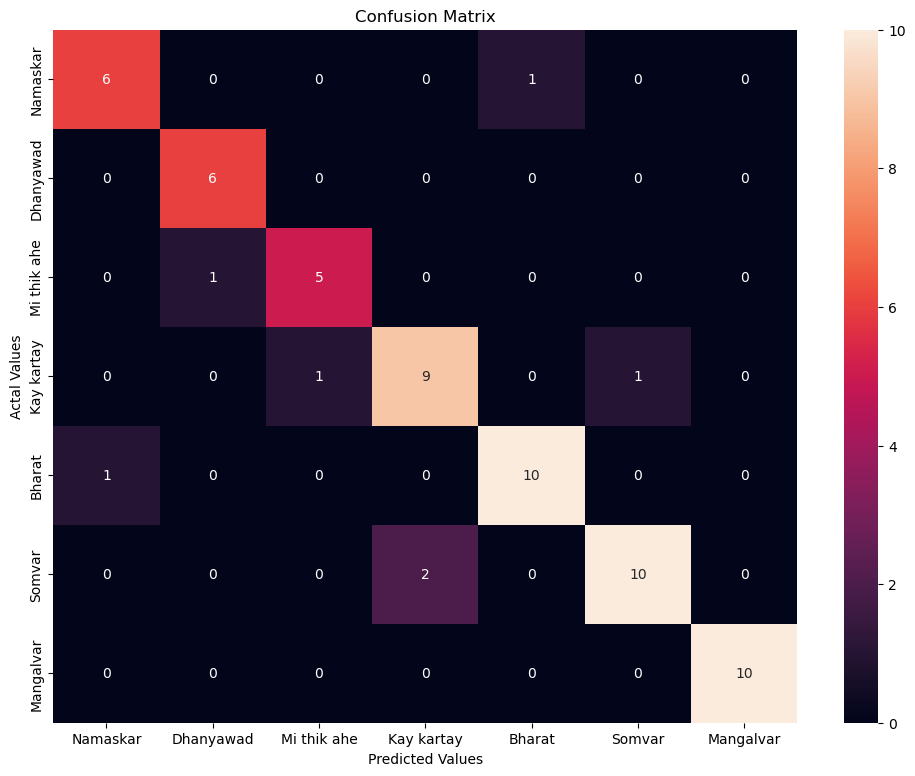

In [55]:
import pandas as pd
from sklearn.metrics import confusion_matrix

cm = confusion_matrix(ytrue, yhat)
cm_df = pd.DataFrame(cm,
                     index = ['Namaskar', 'Dhanyawad', 'Mi thik ahe', 'Kay kartay','Bharat','Somvar','Mangalvar'], 
                     columns = ['Namaskar', 'Dhanyawad', 'Mi thik ahe', 'Kay kartay','Bharat','Somvar','Mangalvar'])

#Plotting the confusion matrix
plt.figure(figsize=(12,9))
sns.heatmap(cm_df, annot=True)
plt.title('Confusion Matrix')
plt.ylabel('Actal Values')
plt.xlabel('Predicted Values')
plt.show()

In [56]:
cf_matrix = multilabel_confusion_matrix(ytrue, yhat)
cf_matrix

array([[[55,  1],
        [ 1,  6]],

       [[56,  1],
        [ 0,  6]],

       [[56,  1],
        [ 1,  5]],

       [[50,  2],
        [ 2,  9]],

       [[51,  1],
        [ 1, 10]],

       [[50,  1],
        [ 2, 10]],

       [[53,  0],
        [ 0, 10]]], dtype=int64)

In [57]:
print(cf_matrix.shape)

(7, 2, 2)


In [58]:
accuracy_score(ytrue, yhat)

0.8888888888888888

# 11. Test in Real Time

In [59]:
colors = [(245,117,16), (117,245,16), (16,117,245), (16,117,245),(117,245,16), (16,117,245), (16,117,245)]
def prob_viz(res, actions, input_frame, colors):
    output_frame = input_frame.copy()
    for num, prob in enumerate(res):
        cv2.rectangle(output_frame, (0,60+num*40), (int(prob*100), 90+num*40), colors[num], -1)
        cv2.putText(output_frame, actions[num], (0, 85+num*40), cv2.FONT_HERSHEY_SIMPLEX, 1, (255,255,255), 2, cv2.LINE_AA)
        
    return output_frame

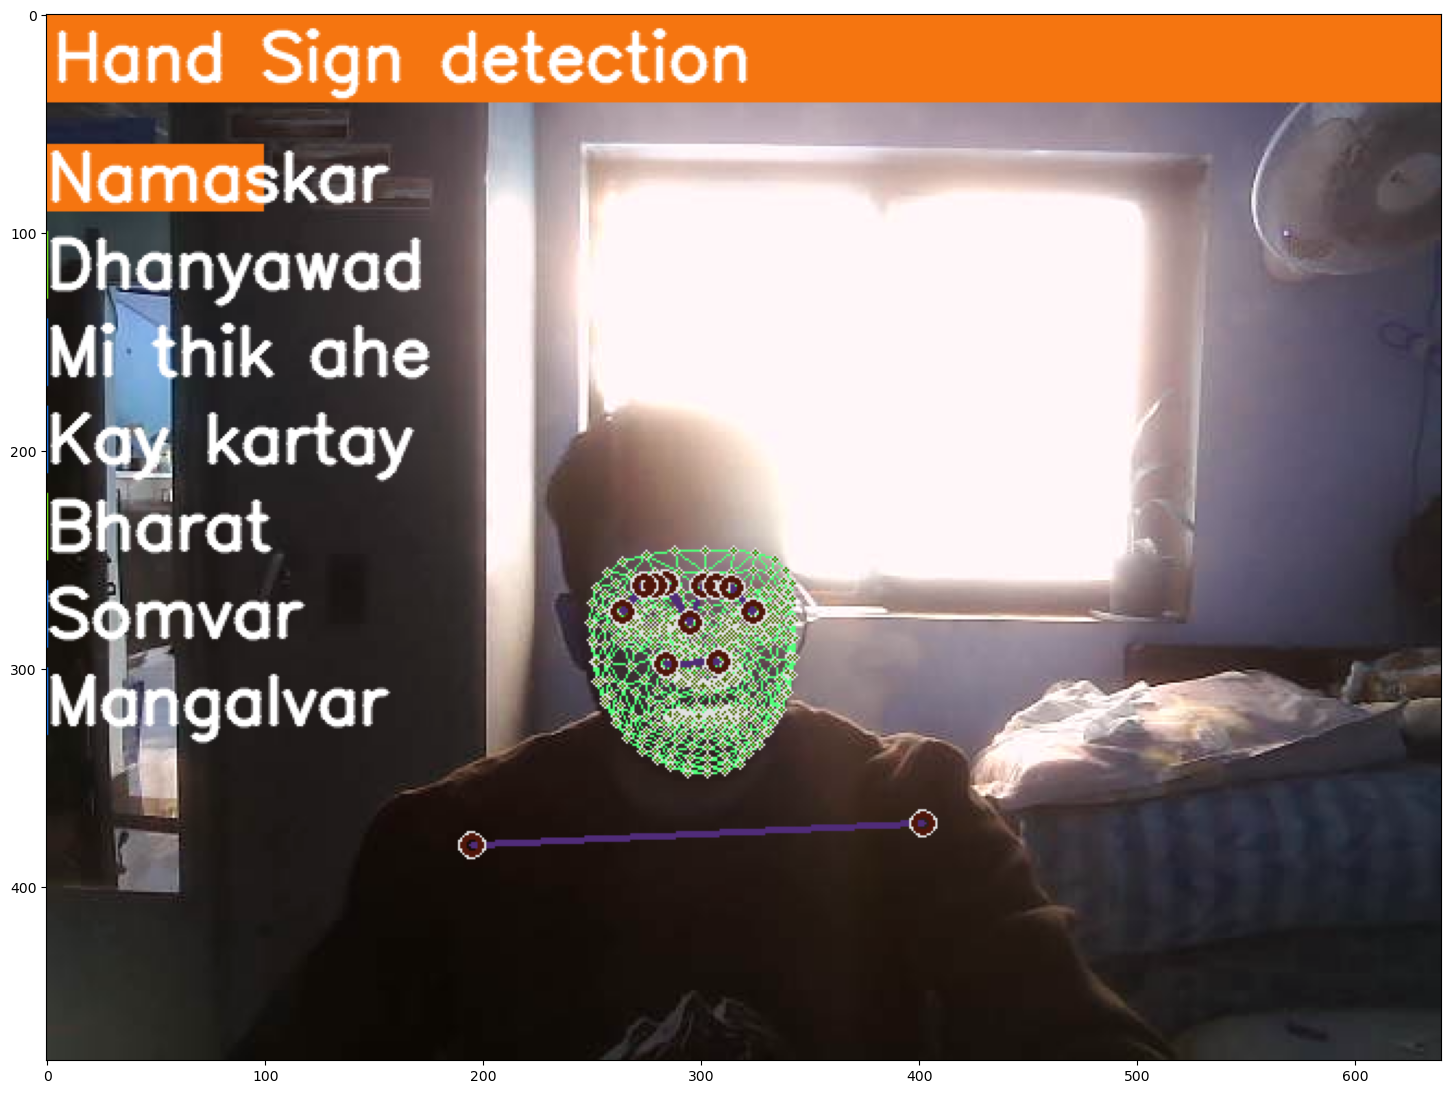

In [93]:
plt.figure(figsize=(18,18))
plt.imshow(prob_viz(res, actions, image, colors))

In [94]:
print(type(sequence))

sequence.reverse()

<class 'list'>


In [95]:
len(sequence)

10

In [96]:
sequence.append('def')

In [97]:
sequence.reverse()

In [98]:
sequence[-30:]

['def',
 array([ 0.47586489,  0.60136801, -0.62570584, ...,  0.4181779 ,
         0.93153244, -0.02538024]),
 array([ 0.47558349,  0.60133213, -0.53990901, ...,  0.43830958,
         1.00569737, -0.04457576]),
 array([ 0.46896774,  0.60139239, -0.65023863, ...,  0.        ,
         0.        ,  0.        ]),
 array([ 0.46829614,  0.60196131, -0.71758974, ...,  0.        ,
         0.        ,  0.        ]),
 array([ 0.46924701,  0.60183221, -0.77400947, ...,  0.        ,
         0.        ,  0.        ]),
 array([ 0.47348648,  0.59491658, -0.81362516, ...,  0.        ,
         0.        ,  0.        ]),
 array([ 0.47245544,  0.58006102, -1.08153236, ...,  0.        ,
         0.        ,  0.        ]),
 array([ 0.471872  ,  0.58033401, -1.00337863, ...,  0.        ,
         0.        ,  0.        ]),
 array([ 0.46773642,  0.58104926, -1.06903815, ...,  0.        ,
         0.        ,  0.        ]),
 array([ 0.46118063,  0.58241534, -1.1114589 , ...,  0.        ,
         0.       

In [66]:
t1 = gtts.gTTS("Namaskār") 

In [67]:
t2= gtts.gTTS("Dhanyavād") 

In [68]:
t3= gtts.gTTS("Mī ṭhīk āhē") 

In [69]:
t4 = gtts.gTTS("Kāy karatay") 

In [70]:
t5 = gtts.gTTS("Bharat") 

In [71]:
t6 = gtts.gTTS("Sōmavār") 

In [72]:
t7 = gtts.gTTS("Maṅgaḷavār") 

In [73]:
t1.save("C:\\Users\\shrey\\Documents\\SLR - Copy\\Audio\\hello.mp3") 

In [80]:
t2.save("C:\\Users\\shrey\\Documents\\SLR - Copy\\Audio\\Dhanyavad.mp3") 

In [74]:
t3.save('C:\\Users\\shrey\\Documents\\SLR - Copy\\Audio\\Mi thik ahe.mp3') 

In [75]:
t4.save("C:\\Users\\shrey\\Documents\\SLR - Copy\\Audio\\kay karatay.mp3") 

In [77]:
t5.save("C:\\Users\\shrey\\Documents\\SLR - Copy\\Audio\\Bharat.mp3") 

In [78]:
t6.save("C:\\Users\\shrey\\Documents\\SLR - Copy\\Audio\\Somavar.mp3") 

In [79]:
t7.save("C:\\Users\\shrey\\Documents\\SLR - Copy\\Audio\\Mangalvar.mp3") 

In [81]:
hello="C:\\Users\\shrey\\Documents\\SLR - Copy\\Audio\\hello.mp3"

In [82]:
Ty="C:\\Users\\shrey\\Documents\\SLR - Copy\\Audio\\Dhanyavad.mp3"

In [83]:
fine='C:\\Users\\shrey\\Documents\\SLR - Copy\\Audio\\Mi thik ahe.mp3'

In [84]:
wrud="C:\\Users\\shrey\\Documents\\SLR - Copy\\Audio\\kay karatay.mp3"

In [85]:
india='C:\\Users\\shrey\\Documents\\SLR - Copy\\Audio\\Bharat.mp3'

In [86]:
mon="C:\\Users\\shrey\\Documents\\SLR - Copy\\Audio\\Somavar.mp3"

In [87]:
tues="C:\\Users\\shrey\\Documents\\SLR - Copy\\Audio\\Mangalvar.mp3"

In [100]:
# 1. New detection variables
sequence = []
sentence = []
threshold = 0.8

cap = cv2.VideoCapture(0)
# Set mediapipe model 
with mp_holistic.Holistic(min_detection_confidence=0.5, min_tracking_confidence=0.5) as holistic:
    while cap.isOpened():

        # Read feed
        ret, frame = cap.read()

        # Make detections
        image, results = mediapipe_detection(frame, holistic)
        print(results)
        
        # Draw landmarks
        draw_styled_landmarks(image, results)
        
        # 2. Prediction logic
        keypoints = extract_keypoints(results)
#         sequence.insert(0,keypoints)
#         sequence = sequence[:30]
        sequence.append(keypoints)
        sequence = sequence[-10:]
        
        if len(sequence) == 10:
            res = model.predict(np.expand_dims(sequence, axis=0))[0]
            print("Op",actions[np.argmax(res)])
            
            
            
            
        #3. Viz logic
            if res[np.argmax(res)] > threshold: 
                if len(sentence) > 0: 
                    if actions[np.argmax(res)] != sentence[-1]:
                        sentence.append(actions[np.argmax(res)])
                        print("In If Op",actions[np.argmax(res)])
                        
                        if( actions[np.argmax(res)] == "Namaskar"):
                            #print("I am hello")
                            playsound(hello) 
                            
                        if( actions[np.argmax(res)] == "Dhanyawad"):
                            #print("I am ilove you")
                            playsound(Ty) 
                            
                        if( actions[np.argmax(res)] == "Mi thik ahe"):
                            #print("I am like")
                            playsound(fine) 
                            
                        if( actions[np.argmax(res)] == "Kay kartay"):
                            #print("I am thank You ")
                            playsound(wrud)
                            
                        if( actions[np.argmax(res)] == "Bharat"):
                            #print("I am thank You ")
                            playsound(india) 
                        
                        if( actions[np.argmax(res)] == "Somvar"):
                            #print("I am thank You ")
                            playsound(mon) 
                            
                        if( actions[np.argmax(res)] == "Mangalvar"):
                            #print("I am thank You ")
                            playsound(tues) 
                            
                        
                else:
                    sentence.append(actions[np.argmax(res)])

            if len(sentence) > 5: 
                sentence = sentence[-5:]
                print("Sentence op",sentence)

            # Viz probabilities
            image = prob_viz(res, actions, image, colors)
            
        cv2.rectangle(image, (0,0), (640, 40), (245, 117, 16), -1)
        cv2.putText(image, "Hand Sign detection", (3,30), 
                       cv2.FONT_HERSHEY_SIMPLEX, 1, (255, 255, 255), 2, cv2.LINE_AA)
        
        # Show to screen
        cv2.imshow('OpenCV Feed', image)

        # Break gracefully
        if cv2.waitKey(10) & 0xFF == ord('q'):
            break
    cap.release()
    cv2.destroyAllWindows()

<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
1/1 [==============================] - 0s 12ms/step
Op Namaskar
<class 'mediapipe.python.solution_base.SolutionOutputs'>
1/1 [==============================] - 0s 12ms/step
Op Namaskar
<class 'mediapipe.python.solution_base.SolutionOutputs'>
1/1 [==============================] - 0s 12ms/step
Op Namaskar
<class 'mediapipe.python.solution_base.SolutionOutputs'>
1/1 [==============================] - 0s 12ms/step
Op Namaskar
<cl

1/1 [==============================] - 0s 11ms/step
Op Namaskar
In If Op Namaskar
<class 'mediapipe.python.solution_base.SolutionOutputs'>
1/1 [==============================] - 0s 11ms/step
Op Namaskar
<class 'mediapipe.python.solution_base.SolutionOutputs'>
1/1 [==============================] - 0s 12ms/step
Op Namaskar
<class 'mediapipe.python.solution_base.SolutionOutputs'>
1/1 [==============================] - 0s 12ms/step
Op Namaskar
<class 'mediapipe.python.solution_base.SolutionOutputs'>
1/1 [==============================] - 0s 12ms/step
Op Kay kartay
In If Op Kay kartay
Sentence op ['Bharat', 'Namaskar', 'Somvar', 'Namaskar', 'Kay kartay']
<class 'mediapipe.python.solution_base.SolutionOutputs'>
1/1 [==============================] - 0s 12ms/step
Op Kay kartay
<class 'mediapipe.python.solution_base.SolutionOutputs'>
1/1 [==============================] - 0s 12ms/step
Op Kay kartay
<class 'mediapipe.python.solution_base.SolutionOutputs'>
1/1 [==============================] -

1/1 [==============================] - 0s 12ms/step
Op Namaskar
<class 'mediapipe.python.solution_base.SolutionOutputs'>
1/1 [==============================] - 0s 12ms/step
Op Namaskar
<class 'mediapipe.python.solution_base.SolutionOutputs'>
1/1 [==============================] - 0s 11ms/step
Op Namaskar
<class 'mediapipe.python.solution_base.SolutionOutputs'>
1/1 [==============================] - 0s 12ms/step
Op Namaskar
<class 'mediapipe.python.solution_base.SolutionOutputs'>
1/1 [==============================] - 0s 12ms/step
Op Namaskar
<class 'mediapipe.python.solution_base.SolutionOutputs'>
1/1 [==============================] - 0s 12ms/step
Op Namaskar
<class 'mediapipe.python.solution_base.SolutionOutputs'>
1/1 [==============================] - 0s 12ms/step
Op Namaskar
<class 'mediapipe.python.solution_base.SolutionOutputs'>
1/1 [==============================] - 0s 11ms/step
Op Namaskar
<class 'mediapipe.python.solution_base.SolutionOutputs'>
1/1 [===========================

1/1 [==============================] - 0s 12ms/step
Op Kay kartay
<class 'mediapipe.python.solution_base.SolutionOutputs'>
1/1 [==============================] - 0s 12ms/step
Op Kay kartay
<class 'mediapipe.python.solution_base.SolutionOutputs'>
1/1 [==============================] - 0s 12ms/step
Op Kay kartay
<class 'mediapipe.python.solution_base.SolutionOutputs'>
1/1 [==============================] - 0s 12ms/step
Op Kay kartay
<class 'mediapipe.python.solution_base.SolutionOutputs'>
1/1 [==============================] - 0s 12ms/step
Op Kay kartay
<class 'mediapipe.python.solution_base.SolutionOutputs'>
1/1 [==============================] - 0s 13ms/step
Op Kay kartay
<class 'mediapipe.python.solution_base.SolutionOutputs'>
1/1 [==============================] - 0s 12ms/step
Op Kay kartay
<class 'mediapipe.python.solution_base.SolutionOutputs'>
1/1 [==============================] - 0s 12ms/step
Op Kay kartay
<class 'mediapipe.python.solution_base.SolutionOutputs'>
1/1 [===========

1/1 [==============================] - 0s 12ms/step
Op Somvar
<class 'mediapipe.python.solution_base.SolutionOutputs'>
1/1 [==============================] - 0s 12ms/step
Op Somvar
<class 'mediapipe.python.solution_base.SolutionOutputs'>
1/1 [==============================] - 0s 12ms/step
Op Somvar
<class 'mediapipe.python.solution_base.SolutionOutputs'>
1/1 [==============================] - 0s 11ms/step
Op Somvar
<class 'mediapipe.python.solution_base.SolutionOutputs'>
1/1 [==============================] - 0s 11ms/step
Op Somvar
<class 'mediapipe.python.solution_base.SolutionOutputs'>
1/1 [==============================] - 0s 12ms/step
Op Somvar
<class 'mediapipe.python.solution_base.SolutionOutputs'>
1/1 [==============================] - 0s 12ms/step
Op Somvar
<class 'mediapipe.python.solution_base.SolutionOutputs'>
1/1 [==============================] - 0s 11ms/step
Op Somvar
<class 'mediapipe.python.solution_base.SolutionOutputs'>
1/1 [==============================] - 0s 12ms/s

1/1 [==============================] - 0s 12ms/step
Op Mangalvar
In If Op Mangalvar
Sentence op ['Kay kartay', 'Somvar', 'Mangalvar', 'Somvar', 'Mangalvar']
<class 'mediapipe.python.solution_base.SolutionOutputs'>
1/1 [==============================] - 0s 12ms/step
Op Mangalvar
<class 'mediapipe.python.solution_base.SolutionOutputs'>
1/1 [==============================] - 0s 12ms/step
Op Mangalvar
<class 'mediapipe.python.solution_base.SolutionOutputs'>
1/1 [==============================] - 0s 12ms/step
Op Somvar
In If Op Somvar
Sentence op ['Somvar', 'Mangalvar', 'Somvar', 'Mangalvar', 'Somvar']
<class 'mediapipe.python.solution_base.SolutionOutputs'>
1/1 [==============================] - 0s 12ms/step
Op Somvar
<class 'mediapipe.python.solution_base.SolutionOutputs'>
1/1 [==============================] - 0s 11ms/step
Op Somvar
<class 'mediapipe.python.solution_base.SolutionOutputs'>
1/1 [==============================] - 0s 12ms/step
Op Somvar
<class 'mediapipe.python.solution_base

1/1 [==============================] - 0s 12ms/step
Op Somvar
<class 'mediapipe.python.solution_base.SolutionOutputs'>
1/1 [==============================] - 0s 12ms/step
Op Somvar
<class 'mediapipe.python.solution_base.SolutionOutputs'>
1/1 [==============================] - 0s 12ms/step
Op Somvar
<class 'mediapipe.python.solution_base.SolutionOutputs'>
1/1 [==============================] - 0s 12ms/step
Op Somvar
<class 'mediapipe.python.solution_base.SolutionOutputs'>
1/1 [==============================] - 0s 12ms/step
Op Somvar
<class 'mediapipe.python.solution_base.SolutionOutputs'>
1/1 [==============================] - 0s 12ms/step
Op Somvar
<class 'mediapipe.python.solution_base.SolutionOutputs'>
1/1 [==============================] - 0s 12ms/step
Op Somvar
<class 'mediapipe.python.solution_base.SolutionOutputs'>
1/1 [==============================] - 0s 12ms/step
Op Somvar
<class 'mediapipe.python.solution_base.SolutionOutputs'>
1/1 [==============================] - 0s 11ms/s

In [89]:
cap.release()
cv2.destroyAllWindows()

In [90]:
res[np.argmax(res)] > threshold

True

In [99]:
(num_sequences,30,1662)

NameError: name 'num_sequences' is not defined

In [92]:
model.predict(np.expand_dims(X_test[0], axis=0))

1/1 [==============================] - 0s 12ms/step


array([[1.0000000e+00, 5.8177262e-16, 1.9612438e-10, 3.6993589e-10,
        3.1058669e-08, 1.9182337e-16, 3.2014619e-17]], dtype=float32)